### TODO

- Simplify further?
    - Stac search per point instead of the hilbert distances shenanigans
    - Instead of 500 points per thread on a dataloader, just have each thread work on 1 point at a time
- Add error catching to Queued Futures

# Notebook prep

In [1]:
%load_ext autoreload
%autoreload 2

## Install the mosaiks package

In [2]:
# Locally
# !pip install -e .. --upgrade

In [4]:
# From github
# 🚨 Make sure you update github token in the secrets file 🚨
# import src.mosaiks.utils as utl
# mosaiks_package_link = utl.get_mosaiks_package_link
# !pip install {mosaiks_package_link} --upgrade

## Import packages

In [5]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
import sys
import os
import warnings

sys.path += ["../"]
warnings.filterwarnings("ignore")

In [8]:
from pathlib import Path
import mosaiks.utils as utl
from mosaiks.featurize import RCF

## Setup Rasterio

In [9]:
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

# Load params + defaults

In [10]:
featurization_config = utl.load_yaml_config("featurisation.yaml")

satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[
    featurization_config["satellite_search_params"]["satellite_name"]
]

In [11]:
mosaiks_column_names = [
    f"mosaiks_{i}" for i in range(featurization_config["model"]["num_features"])
]
test_mosaiks_folder_path = Path("test_outputs")

In [12]:
model = RCF(
    featurization_config["model"]["num_features"],
    featurization_config["model"]["kernel_size"],
    len(satellite_config["bands"]),
)

# Load Data

In [13]:
request_points_gdf = utl.load_df_w_latlons_to_gdf(
    dataset_name=featurization_config["coord_set_name"]
)

In [14]:
# Select random 1000 points (for testing)
points_gdf = request_points_gdf.iloc[:1000]

# Simple non-Dask run

In [15]:
test_points_gdf = points_gdf.iloc[1:2]

### Check pipeline run

In [19]:
from mosaiks.run import full_pipeline

In [20]:
%%time
df_1 = full_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    column_names=mosaiks_column_names,
    save_folder_path=test_mosaiks_folder_path,
    save_filename="df_TEST.csv",
    return_df=True,
)
df_1

CPU times: user 810 ms, sys: 343 ms, total: 1.15 s
Wall time: 4.77 s


,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,mosaiks_6,mosaiks_7,mosaiks_8,mosaiks_9,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,0.0,1.558916,0.0,0.0,2.178434,0.000568,1.242502,0.0,0.416308,1.785282,...,5.091598,0.0,3.155938,0.0,6.648976,1.588532,0.007068,2.786207,3.821659,0.000024


### Check pipeline components

In [34]:
from mosaiks.fetch import fetch_image_refs, create_data_loader
from mosaiks.featurize import create_features
import pandas as pd

In [23]:
%%time
points_gdf_with_stac = fetch_image_refs(
    test_points_gdf, 
    featurization_config['satellite_search_params']
)

CPU times: user 84.6 ms, sys: 4.22 ms, total: 88.8 ms
Wall time: 1.1 s


In [24]:
points_gdf_with_stac

,Lat,Lon,pc11_s_id,pc11_d_id,pc11_sd_id,pc11_tv_id,tv_name,is_urban,shrid,geometry,stac_item
319819,34.554878,74.434486,1,1,1,16,Khurhama,0,11-01-000016,POINT (74.43449 34.55488),<Item id=LC08_L2SP_149036_20130518_02_T1>


In [25]:
from mosaiks.fetch import fetch_image_crop, display_image

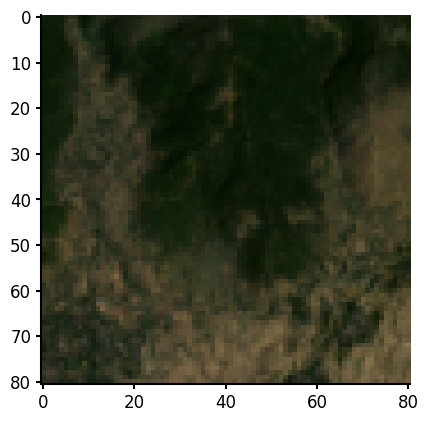

In [26]:
image = fetch_image_crop(
    lon=points_gdf_with_stac.iloc[0]["Lon"],
    lat=points_gdf_with_stac.iloc[0]["Lat"],
    stac_item=points_gdf_with_stac.iloc[0]["stac_item"],
    buffer=satellite_config["buffer_distance"],
    bands=satellite_config["bands"],
    resolution=satellite_config["resolution"],
    dtype=satellite_config["dtype"],
    normalise=True,
)

display_image(image)

In [27]:
# for multiple images ######
# for stac_item in points_gdf_with_stac.iloc[0]["stac_item"]:
#     image = fetch_image_crop(
#         lon=points_gdf_with_stac.iloc[0]["Lon"],
#         lat=points_gdf_with_stac.iloc[0]["Lat"],
#         stac_item=stac_item,
#         buffer=satellite_config["buffer_distance"],
#         bands=satellite_config["bands"],
#         resolution=satellite_config["resolution"],
#         dtype="uint16",
#         normalise=True,
#     )

#     display_numpy_image(image)

In [28]:
%%time

data_loader = create_data_loader(
    points_gdf_with_stac=points_gdf_with_stac,
    satellite_params=satellite_config,
    batch_size=featurization_config["model"]["batch_size"],
)

CPU times: user 1.37 ms, sys: 23 µs, total: 1.4 ms
Wall time: 1.39 ms


In [29]:
%%time
X_features = create_features(
    dataloader=data_loader,
    n_features=featurization_config["model"]["num_features"],
    model=model,
    device=featurization_config["model"]["device"],
    min_image_edge=satellite_config["min_image_edge"],
)

CPU times: user 218 ms, sys: 201 ms, total: 419 ms
Wall time: 462 ms


In [30]:
%%time
df = pd.DataFrame(
    data=X_features, index=test_points_gdf.index, columns=mosaiks_column_names
)
df

CPU times: user 438 µs, sys: 68 µs, total: 506 µs
Wall time: 422 µs


,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,mosaiks_6,mosaiks_7,mosaiks_8,mosaiks_9,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,0.0,1.558916,0.0,0.0,2.178434,0.000568,1.242502,0.0,0.416308,1.785282,...,5.091598,0.0,3.155938,0.0,6.648976,1.588532,0.007068,2.786207,3.821659,0.000024


In [31]:
%%time
utl.save_dataframe(
    df=df, file_path=f"{test_mosaiks_folder_path}/df_TEST.csv"
)

CPU times: user 9.93 ms, sys: 1.87 ms, total: 11.8 ms
Wall time: 11.2 ms


# Dask runs

In [35]:
### Connect to LOCAL CLIENT
from mosaiks.dask import get_local_dask_client
client = get_local_dask_client(
    featurization_config["dask"]["n_workers"],
    featurization_config["dask"]["threads_per_worker"],
)

INFO:root:http://127.0.0.1:8787/status


In [36]:
### or connect to GATEWAY
# from mosaiks.dask import get_gateway_cluster_client
# cluster, client = get_gateway_cluster_client()
# cluster

In [37]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53568,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53582,Total threads: 4
Dashboard: http://127.0.0.1:53586/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53571,


In [38]:
mosaiks_folder_path = Path("test_outputs") #utl.make_output_folder_path(featurization_config)
os.makedirs(mosaiks_folder_path, exist_ok=True)

## Method 1 (Preferred) - Queued Futures

In [39]:
from mosaiks.dask import run_queued_futures_pipeline

In [41]:
%%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_queued_futures_pipeline(
    points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    column_names=mosaiks_column_names,
    save_folder_path=mosaiks_folder_path,
)

INFO:root:19-May 17:10:50 Trying to kick off initial 8 partitions...
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
INFO:root:There are less partitions than processors. All 1 partitions running.
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/shapely/geometry/geo.py:123: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
  raise GeometryTypeError("Unknown geometry type: %s" % geom_type)
INFO:root:19-May 17:10:58 Finished.


CPU times: user 325 ms, sys: 67.4 ms, total: 393 ms
Wall time: 7.5 s


## Method 2 - Batched Delayed

In [42]:
from mosaiks.dask import run_batched_delayed_pipeline

In [43]:
%%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_batched_delayed_pipeline(
    points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    column_names=mosaiks_column_names,
    save_folder_path=mosaiks_folder_path,
)

/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
INFO:root:n_partitions is smaller than n_concurrent. Running all 1 partitions.
INFO:root:19-May 17:11:32 Running batch: 0 to 0
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/shapely/geometry/geo.py:123: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
  raise GeometryTypeError("Unknown geometry type: %s" % geom_type)


CPU times: user 226 ms, sys: 46.9 ms, total: 273 ms
Wall time: 4.24 s


[]

## Method 3 - Unbatched Delayed

In [44]:
from mosaiks.dask import delayed_pipeline, run_unbatched_delayed_pipeline

### Single task

In [45]:
delayed_task = delayed_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    mosaiks_column_names,
    test_mosaiks_folder_path,
    "TEST_dask_delayed.csv",
)

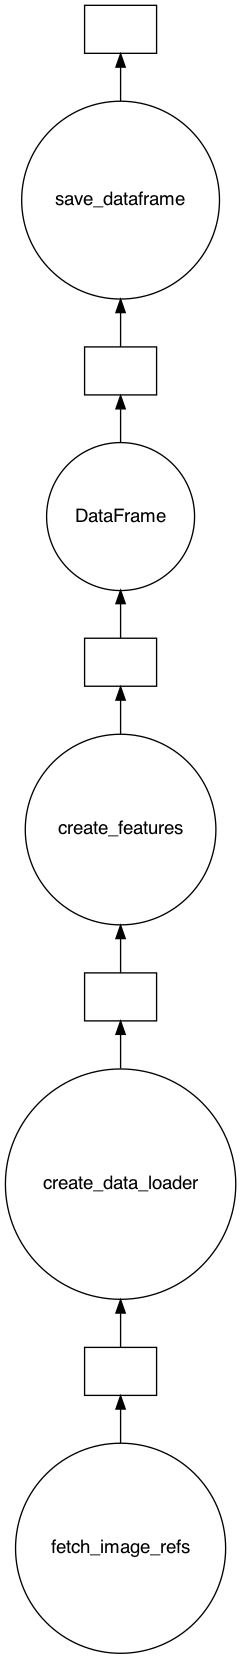

In [46]:
delayed_task.visualize(filename=f"{test_mosaiks_folder_path}/TEST_dask_graph.png")

In [47]:
delayed_task.compute()

/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/shapely/geometry/geo.py:123: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
  raise GeometryTypeError("Unknown geometry type: %s" % geom_type)


### Full run

In [48]:
delayed_task_list = run_unbatched_delayed_pipeline(
    points_gdf=test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    column_names=mosaiks_column_names,
    save_folder_path=mosaiks_folder_path,
)

/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  res = (vals - val_range[0]) * (n / width)
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/dask_geopandas/hilbert_distance.py:110: RuntimeWarning: invalid value encountered in multiply
  res = (vals - val_range[0]) * (n / width)
INFO:root:Distributing 1 points across 500-point partitions results in 1 partitions.
/opt/miniconda3/envs/mosaiks/lib/python3.10/site-packages/shapely/geometry/geo.py:123: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
  raise GeometryTypeError("Unknown geometry type: %s" % geom_type)


# Load checkpoint files and combine

In [49]:
# # simple test
# data = utl.load_dataframe(mosaiks_folder_path / "df_005.parquet.gzip")
# data

In [50]:
checkpoint_filenames = utl.get_filtered_filenames(
    folder_path=mosaiks_folder_path, prefix="df_"
)

combined_df = utl.load_and_combine_dataframes(
    folder_path=mosaiks_folder_path, filenames=checkpoint_filenames
)

combined_df = combined_df.join(points_gdf[["Lat", "Lon", "shrid"]])

print(f"Dataset size in memory (MB): {combined_df.memory_usage().sum() / 1000000}")

Dataset size in memory (MB): 1.50588


In [51]:
combined_filepath = mosaiks_folder_path / "combined_features.parquet.gzip"
utl.save_dataframe(df=combined_df, file_path=combined_filepath)